### Importing libraries and loading digits

Shape dataset is (1797, 64) and each image is 8x8

Shape: (1797, 64)


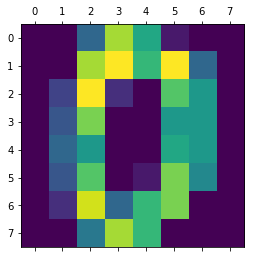

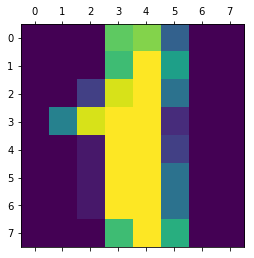

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, pairwise_distances
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

digits = load_digits(n_class=10, return_X_y=False)
print('Shape:', digits.data.shape)

plt.matshow(digits.images[0]) 
plt.matshow(digits.images[1]) 

### Utilities and helpers

In [3]:
def show_result(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)

    print('Accuracy score: %.8f' % accuracy_score(y_true, y_pred))
    print()
    print("Confusion Matrix")
    print(cm)

    plt.scatter(y_true, y_pred, alpha=0.25)

def train_and_test(classifier):
    classifier.fit(X_train, y_train)
    Y = classifier.predict(X_test)
    show_result(y_test, Y)
    
def find_best_k(classifier):
    parameters = {'k':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
    grid_search = GridSearchCV(classifier, parameters, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)

    cvres = grid_search.cv_results_
    for ms, params in zip(cvres["mean_test_score"], cvres["params"]):
        print(int(params["k"]), ':', np.sqrt(-ms))
    
    return grid_search.best_params_["k"]

### Splitting data

In [4]:
indices = np.arange(digits.data.shape[0])
np.random.shuffle(indices)

data = digits.data[indices]
target = digits.target[indices]

(X_train, X_test, y_train, y_test) = train_test_split(digits.data, digits.target, test_size=0.2)

### Naive  kNN implementation

In [5]:
class NaiveKNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, k = None):
        self.k = k

    def fit(self, X, y):
        self.X = X
        self.y = y

    def predict(self, X_test):
        res = np.zeros(len(X_test))
        if self.k is None: 
            return res
        
        diff = X_test[:, np.newaxis, :] - self.X[np.newaxis, :, :]
        diff = diff ** 2
        diff = diff.sum(-1)
        diff = np.argsort(diff, axis=1)[:, :self.k]
        return np.apply_along_axis(self.__weight, 1, diff)
    
    def __weight(self, a):
        return np.bincount(self.y[a]).argmax()

### kNN with Potential Function

In [6]:
class PotentialKNNClassifier(BaseEstimator, ClassifierMixin):
    def fit(self, X, y):
        self.X = self.__normalize(X)
        self.y = y
        self.classes = np.arange(self.y.max() + 1)
        self.gammas = np.zeros(self.X.shape[0])
        
        epsilon = 0.95
        iteration = 0
        max_score = -1
        max_gammas = np.copy(self.gammas)
        max_iterations = 50000
        convergence_check_iterations = 750
        
        while True:
            index = np.random.randint(0, high=self.X.shape[0], size=1)
            prediction = self.__fit(X[index])
            change = np.argwhere(prediction != self.y[index])
            if len(prediction[change]) > 0:
                self.gammas[index] = self.gammas[index] + 1
            
            if iteration % convergence_check_iterations == 0:
                score = self.score(X, y)
                if score > epsilon: break
                    
                if score > max_score:
                    print(iteration, ':', score, '-- updating max score')
                    max_score = score
                    max_gammas = np.copy(self.gammas)
                else:
                    print(iteration, ':', score)
                    
            if iteration > max_iterations:
                self.gammas = max_gammas
                print('Stopping at max score:', max_score)
                break
                
            iteration += 1
                

    def predict(self, X_test):
        return self.__fit(X_test)
    
    def __normalize(self, X):
        return (X - X.mean()) / X.std()
    
    def __fit(self, X_test):
        distances = X_test[:, np.newaxis, :] - self.X[np.newaxis, :, :]
        distances = distances ** 2
        distances = distances.sum(-1)
        
        max = np.full((distances.shape[0],), -1)
        max_class = np.full((distances.shape[0],), -1)
        
        for _, c in enumerate(self.classes):
            indices = np.argwhere(self.y == c)
            
            gammas = self.gammas[indices].ravel()
            dist = distances[:, indices]
            dist = dist.reshape(dist.shape[0], dist.shape[1])
            val = self.__kernel1(dist).dot(gammas)
            
            change = np.argwhere(val > max)
            max[change] = val[change]
            max_class[change] = c

        return max_class
    
    def __kernel1(self, dist):
        dist = dist/10000
        ones = np.ones(dist.shape)
        return ones / (dist + ones)
    
    def __kernel2(self, dist):
        rad = 10000
        alpha = 1
        return np.exp(-dist/rad)/(dist + alpha)

### Weighted kNN

0 : 0.09672929714683368 -- updating max score
750 : 0.2978427279053584 -- updating max score
1500 : 0.5142658315935977 -- updating max score
2250 : 0.5880306193458594 -- updating max score
3000 : 0.5824634655532359
3750 : 0.7842727905358385 -- updating max score
4500 : 0.7585247042449548
5250 : 0.6597077244258872
6000 : 0.6256089074460682
6750 : 0.7668754349338901
7500 : 0.8392484342379958 -- updating max score
8250 : 0.7835768963117606
9000 : 0.8622129436325678 -- updating max score
9750 : 0.8037578288100209
10500 : 0.8865692414752957 -- updating max score
11250 : 0.8107167710508003
12000 : 0.8427279053583855
12750 : 0.7877522616562282
13500 : 0.6840640222686152
14250 : 0.8364648573416841
15000 : 0.8698677800974252
15750 : 0.8573416840640222
16500 : 0.824634655532359
17250 : 0.8684759916492694
18000 : 0.8315935977731385
18750 : 0.8872651356993737 -- updating max score
19500 : 0.7202505219206681
20250 : 0.8649965205288797
21000 : 0.8295059151009047
21750 : 0.8733472512178149
22500 : 0.

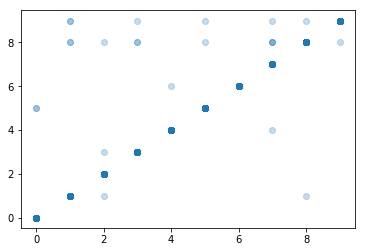

In [7]:
train_and_test(PotentialKNNClassifier())

### Outputing naive KNN classifier

Accuracy score: 0.98888889

Confusion Matrix
[[30  0  0  0  0  0  0  0  0  0]
 [ 0 43  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  1  0  0]
 [ 0  0  0  0 29  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0 31  0  0  0]
 [ 0  0  0  0  0  0  0 41  0  1]
 [ 0  1  0  0  0  0  0  0 39  0]
 [ 0  0  0  0  0  0  0  0  1 35]]


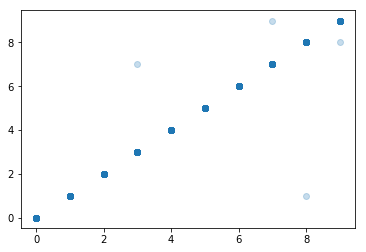

In [8]:
k = 3
train_and_test(NaiveKNNClassifier(k))

### Using KNeighborsClassifier from sklearn to test data

Accuracy score: 0.98888889

Confusion Matrix
[[30  0  0  0  0  0  0  0  0  0]
 [ 0 43  0  0  0  0  0  0  0  0]
 [ 0  0 40  0  0  0  0  0  0  0]
 [ 0  0  0 34  0  0  0  1  0  0]
 [ 0  0  0  0 29  0  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  0 31  0  0  0]
 [ 0  0  0  0  0  0  0 41  0  1]
 [ 0  1  0  0  0  0  0  0 39  0]
 [ 0  0  0  0  0  0  0  0  1 35]]


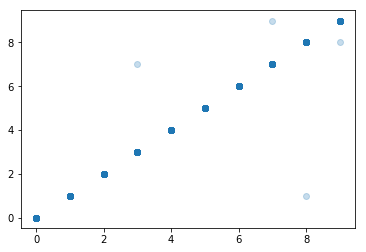

In [9]:
train_and_test(KNeighborsClassifier(k))